In [1]:
import os
import warnings

import emcee
import numpy as np
from astropy.io import ascii, fits
from astropy.nddata import Cutout2D
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from photutils import CircularAperture
from skimage.transform import rotate, rescale
from matplotlib.ticker import MultipleLocator

from scipy.stats import kstest

import sys
sys.path.append('../core/')

from misalignment_angle import get_mis, get_shadow_pa, get_shadow_x
from disk_fitting import get_theta0, func_cps, log_like, log_prior, log_prob

In [3]:
# target
t = 'HD_100453'
iso = '12CO' # isotopologue

# Path to data (FITS file)
path = '../../data/'
path_sphere = f"../../data/HD_100453/SPHERE/HD100453_ZIMPOL_Ip_Qphi.fits"

# Path to database where results are stored
path_working_place_inner = '../../workplace/inner_disk_models/mcmc_fitting/'
path_working_place_outer = '../../workplace/outer_disks/mcmc_fitting/'

In [4]:
# load stellar parameters
stellar_parameters = ascii.read(os.path.join(path, 'sample_properties', 'stellar_properties.dat'))
stellar_masses = ascii.read(os.path.join(path, 'sample_properties', 'stellar_masses.dat'))
stellar_names_latex = ascii.read(os.path.join(path, 'sample_properties', 'stellar_names_latex.dat'))
plot_parameters = ascii.read(os.path.join(path, 'sample_properties', 'plot_parameters.dat'))

In [5]:
# ---- MCMC parameters
inner_nwalkers = 100 # 200
inner_nsteps = 2000 # 10000

outer_nwalkers = 50 # 100
outer_nburnin = 200 # 2000
outer_nsteps = 200 # 2000
iterations = 2

In [6]:
# disk scaling law
z = lambda r: 0.1 * r

In [7]:
# ---- plot parameters
vmin = 1
vmax = 10

In [8]:
fit_mode = 'unconstrained'

# mode = 'thin'
mode = 'thick'

In [9]:
# ---- Plotting
labels = np.array([r'$k_\mathrm{c}$',
                   r'$f_\mathrm{c}$',
                   r'$f_\mathrm{h}$',
                   r'$f_\mathrm{Lor}$',
                   r'$l_\mathrm{a}$',
                   r'$l_\mathrm{kr}$',
                   r'$\cos i$',
                   r'$\theta$',
                   r'$c_1$',
                   r'$s_1$', ])

labels_outer = np.array([r'$x_0$',
                         r'$y_0$',
                         r'$i_\mathrm{out}$',
                         r'$\mathrm{PA}_\mathrm{out}$',
                         r'$v_\mathrm{LSR}$',
                         r'$z_0$',
                         r'$\psi$'])

In [10]:
theta_0, indices = get_theta0(fit_mode)

In [11]:
percentiles_3a = np.zeros((1, len(theta_0.compressed()), 3))
percentiles_3b = np.zeros((1, len(theta_0.compressed()), 3))
percentiles_outer_raw = np.zeros(
    (1, len(labels_outer), 3))  # TODO the second dimension is only valid for thick disk geometries
percentiles_outer_rescaled = np.zeros(
    (1, len(labels_outer), 3))  # TODO the second dimension is only valid for thick disk geometries
sp_types = np.array([])
l_star = np.array([])
# m_star = np.array([])
a_r_mas_percentiles = np.zeros((1, 3))
a_r_au_percentiles = np.zeros((1, 3))
i_in_percentiles = np.zeros((1, 3))
pa_in_percentiles = np.zeros((1, 3))
i_out_percentiles = np.zeros((1, 3))
pa_out_percentiles = np.zeros((1, 3))
M1_percentiles = np.zeros((1, 3))
M2_percentiles = np.zeros((1, 3))
alpha_1_percentiles = np.zeros((1, 3))
alpha_2_percentiles = np.zeros((1, 3))
x_1_percentiles = np.zeros((1, 3))
x_2_percentiles = np.zeros((1, 3))
misalignments_sigma = np.zeros(1)
red_chi2 = np.zeros(1)

In [12]:
index_plot_parameters = np.where(t == plot_parameters['NAME'])[0][0]

In [13]:
tmp_r_out = plot_parameters['R_OUT'].data[index_plot_parameters]
if tmp_r_out == 'None':
    tmp_r_out = 40
    warnings.warn('Setting *tmp_r_out* to default value of 40au.')
else:
    tmp_r_out = float(tmp_r_out)
print(f'Outer disk scale height: {z(tmp_r_out):.2f}au')

Outer disk scale height: 4.00au


In [24]:
sampler_3a = emcee.backends.HDFBackend(
    os.path.join(path_working_place_inner, t, fit_mode,
                 f"mcmc_3a_fit_{fit_mode}.hdf5"))
flat_samples_3a = sampler_3a.get_chain(discard=int(inner_nsteps / 50 * 10),
                                       thin=int(inner_nsteps / 50 / 5),
                                       flat=True)

In [25]:
sampler_3b = emcee.backends.HDFBackend(
    os.path.join(path_working_place_inner, t, fit_mode,
                 f"mcmc_3b_fit_{fit_mode}.hdf5"))
flat_samples_3b = sampler_3b.get_chain(discard=int(inner_nsteps / 50 * 10),
                                       thin=int(inner_nsteps / 50 / 5),
                                       flat=True)

In [26]:
# calculate percentiles for parameters
percentiles_3a[0,] = np.array([np.percentile(i, [16, 50, 84]) for i in flat_samples_3a.T])
percentiles_3b[0,] = np.array([np.percentile(i, [16, 50, 84]) for i in flat_samples_3b.T])

tmp_spt_type = stellar_parameters['SP_TYPE'].data[stellar_parameters['NAME'].data == t][0]
if len(tmp_spt_type.split('.')) > 1:
    tmp_spt_type = tmp_spt_type.split('.')[0] + '.' + tmp_spt_type.split('.')[1][0]
else:
    tmp_spt_type = tmp_spt_type[:2]
sp_types = np.append(sp_types, tmp_spt_type)

if indices['l_kr'] is not None:
    tmp_a_r_a = 10 ** np.random.choice(flat_samples_3a.T[indices['l_a'],],
                                       len(flat_samples_3a.T[indices['l_a'],])) / np.sqrt(
        1 + 10 ** (2 * np.random.choice(flat_samples_3a.T[indices['l_kr'],],
                                        len(flat_samples_3a.T[indices['l_kr'],]))))
    tmp_a_r_b = 10 ** np.random.choice(flat_samples_3b.T[indices['l_a'],],
                                       len(flat_samples_3b.T[indices['l_a'],])) / np.sqrt(
        1 + 10 ** (2 * np.random.choice(flat_samples_3b.T[indices['l_kr'],],
                                        len(flat_samples_3b.T[indices['l_kr'],]))))
else:
    tmp_a_r_a = 10 ** np.random.choice(flat_samples_3a.T[indices['l_a'],],
                                       len(flat_samples_3a.T[indices['l_a'],])) / np.sqrt(
        1 + 10 ** (2 * np.random.choice(np.ones(len(flat_samples_3a.T[indices['l_a'],])) * theta_0.data[5])))
    tmp_a_r_b = 10 ** np.random.choice(flat_samples_3b.T[indices['l_a'],],
                                       len(flat_samples_3b.T[indices['l_a'],])) / np.sqrt(
        1 + 10 ** (2 * np.random.choice(np.ones(len(flat_samples_3a.T[indices['l_a'],])) * theta_0.data[5])))
tmp_percentiles_a_r_a = np.percentile(tmp_a_r_a, [16, 50, 84])
tmp_percentiles_a_r_b = np.percentile(tmp_a_r_b, [16, 50, 84])
a_r_mas_percentiles[0,] = np.array(
    [tmp_percentiles_a_r_b[1] - (tmp_percentiles_a_r_a[1] - tmp_percentiles_a_r_a[0]),
     tmp_percentiles_a_r_b[1],
     tmp_percentiles_a_r_b[1] + (tmp_percentiles_a_r_a[2] - tmp_percentiles_a_r_a[1])])
a_r_au_percentiles[0,] = a_r_mas_percentiles[0,] / \
                               stellar_parameters['Plx'].data[stellar_parameters['NAME'].data == t][0]

In [27]:
# --- inner inclination and PA
tmp_i_in_a = np.rad2deg(np.arccos(flat_samples_3a.T[indices['cosi'],]))
tmp_i_in_b = np.rad2deg(np.arccos(flat_samples_3b.T[indices['cosi'],]))
tmp_i_in_percentiles_a = np.percentile(tmp_i_in_a, [16, 50, 84])
tmp_i_in_percentiles_b = np.percentile(tmp_i_in_b, [16, 50, 84])

i_in_percentiles[0,] = np.array(
    [tmp_i_in_percentiles_b[1] - (tmp_i_in_percentiles_a[1] - tmp_i_in_percentiles_a[0]),
     tmp_i_in_percentiles_b[1],
     tmp_i_in_percentiles_b[1] + (tmp_i_in_percentiles_a[2] - tmp_i_in_percentiles_a[1])])

tmp_pa_in_a = np.rad2deg(flat_samples_3a.T[indices['theta'],])
tmp_pa_in_b = np.rad2deg(flat_samples_3b.T[indices['theta'],])

# shift data to [0, 180]
tmp_pa_in_hist_a, tmp_pa_in_bin_edges_a = np.histogram(tmp_pa_in_a, bins=inner_nwalkers, range=(-360, 360))
tmp_pa_in_peak_a = 0.5 * (tmp_pa_in_bin_edges_a[np.argmax(tmp_pa_in_hist_a) + 1] + tmp_pa_in_bin_edges_a[
    np.argmax(tmp_pa_in_hist_a)])
tmp_pa_in_hist_b, tmp_pa_in_bin_edges_b = np.histogram(tmp_pa_in_b, bins=inner_nwalkers, range=(-360, 360))
tmp_pa_in_peak_b = 0.5 * (tmp_pa_in_bin_edges_b[np.argmax(tmp_pa_in_hist_b) + 1] + tmp_pa_in_bin_edges_b[
    np.argmax(tmp_pa_in_hist_b)])

while tmp_pa_in_peak_a < 0:
    tmp_pa_in_peak_a += 180
while tmp_pa_in_peak_a > 180:
    tmp_pa_in_peak_a -= 180
while len(tmp_pa_in_a[tmp_pa_in_a < tmp_pa_in_peak_a - 90]) > 0:
    tmp_pa_in_a[tmp_pa_in_a < tmp_pa_in_peak_a - 90] += 180
while len(tmp_pa_in_a[tmp_pa_in_a > tmp_pa_in_peak_a + 90]) > 0:
    tmp_pa_in_a[tmp_pa_in_a > tmp_pa_in_peak_a + 90] -= 180

while tmp_pa_in_peak_b < 0:
    tmp_pa_in_peak_b += 180
while tmp_pa_in_peak_b > 180:
    tmp_pa_in_peak_b -= 180
while len(tmp_pa_in_b[tmp_pa_in_b < tmp_pa_in_peak_b - 90]) > 0:
    tmp_pa_in_b[tmp_pa_in_b < tmp_pa_in_peak_b - 90] += 180
while len(tmp_pa_in_b[tmp_pa_in_b > tmp_pa_in_peak_b + 90]) > 0:
    tmp_pa_in_b[tmp_pa_in_b > tmp_pa_in_peak_b + 90] -= 180

pa_in_percentiles_a = np.percentile(tmp_pa_in_a, [16, 50, 84])
pa_in_percentiles_b = np.percentile(tmp_pa_in_b, [16, 50, 84])
if pa_in_percentiles_a[1] < 0:
    pa_in_percentiles_a += 180
if pa_in_percentiles_b[1] < 0:
    pa_in_percentiles_b += 180
if pa_in_percentiles_a[1] >= 180:
    pa_in_percentiles_a -= 180
if pa_in_percentiles_b[1] >= 180:
    pa_in_percentiles_b -= 180
percentiles_3a[0, indices['theta'],] = pa_in_percentiles_a
percentiles_3b[0, indices['theta'],] = pa_in_percentiles_b

pa_in_percentiles[0,] = np.array(
    [pa_in_percentiles_b[1] - (pa_in_percentiles_a[1] - pa_in_percentiles_a[0]),
     pa_in_percentiles_b[1],
     pa_in_percentiles_b[1] + (pa_in_percentiles_a[2] - pa_in_percentiles_a[1])])

In [28]:
tmp_i_out_dist = np.zeros((1, outer_nsteps * outer_nwalkers))
tmp_pa_out_dist = np.zeros((1, outer_nsteps * outer_nwalkers))
tmp_i_out_dist_rescaled = np.zeros((1, outer_nsteps * outer_nwalkers))
tmp_pa_out_dist_rescaled = np.zeros((1, outer_nsteps * outer_nwalkers))

tmp_mstar_dist = np.random.normal(loc=stellar_masses['MASS'].data[stellar_masses['NAME'].data == t],
                                  scale=stellar_masses['e_MASS'].data[stellar_masses['NAME'].data == t],
                                  size=outer_nsteps * outer_nwalkers)

In [29]:
sampler = emcee.backends.HDFBackend(
                os.path.join(path_working_place_outer, t, iso, mode,
                             f"{t}_mcmc_fit.hdf5"))
sampler_rescaled = emcee.backends.HDFBackend(
    os.path.join(path_working_place_outer, t, iso, mode,
                 f"{t}_mcmc_fit_rescaled.hdf5"))
posteriors = sampler.get_chain(discard=(iterations - 1) * (outer_nsteps + outer_nburnin) + outer_nburnin,
                               thin=1,
                               flat=True)
posteriors_rescaled = sampler_rescaled.get_chain(
    discard=(iterations - 1) * (outer_nsteps + outer_nburnin) + outer_nburnin,
    thin=1,
    flat=True)

In [30]:
# make inclinations positive
posteriors[:, 2] = np.abs(posteriors[:, 2])
posteriors_rescaled[:, 2] = np.abs(posteriors_rescaled[:, 2])

percentiles_outer_raw[0,] = np.array([np.percentile(i, [16, 50, 84]) for i in posteriors.T])
percentiles_outer_rescaled[0,] = np.array(
    [np.percentile(i, [16, 50, 84]) for i in posteriors_rescaled.T])

tmp_i_out_dist[0,] = np.abs(np.rad2deg(
    np.arcsin(np.sqrt(stellar_masses['MASS'].data[stellar_masses['NAME'].data == t]) *
              np.sin(np.deg2rad(posteriors[:, 2])) / np.sqrt(tmp_mstar_dist))))
tmp_pa_out_dist[0,] = posteriors[:, 3]
tmp_i_out_dist_rescaled[0,] = np.abs(np.rad2deg(
    np.arcsin(np.sqrt(stellar_masses['MASS'].data[stellar_masses['NAME'].data == t]) *
              np.sin(np.deg2rad(posteriors_rescaled[:, 2])) / np.sqrt(tmp_mstar_dist))))
tmp_pa_out_dist_rescaled[0,] = posteriors_rescaled[:, 3]

In [31]:
tmp_i_out_dist = tmp_i_out_dist.ravel()
tmp_pa_out_dist = tmp_pa_out_dist.ravel()
tmp_i_out_dist_rescaled = tmp_i_out_dist_rescaled.ravel()
tmp_pa_out_dist_rescaled = tmp_pa_out_dist_rescaled.ravel()

In [32]:
i_out_percentiles[0,] = np.array([np.nanmedian(tmp_i_out_dist) - (
            np.nanpercentile(tmp_i_out_dist_rescaled, 50) - np.nanpercentile(tmp_i_out_dist_rescaled, 16)),
                                        np.nanmedian(tmp_i_out_dist),
                                        np.nanmedian(tmp_i_out_dist) + (
                                                    np.nanpercentile(tmp_i_out_dist_rescaled,
                                                                     84) - np.nanpercentile(
                                                tmp_i_out_dist_rescaled, 50))])
pa_out_percentiles[0,] = np.array([np.nanmedian(tmp_pa_out_dist) - (
            np.nanpercentile(tmp_i_out_dist_rescaled, 50) - np.nanpercentile(tmp_i_out_dist_rescaled, 16)),
                                         np.nanmedian(tmp_pa_out_dist),
                                         np.nanmedian(tmp_pa_out_dist) + (
                                                     np.nanpercentile(tmp_i_out_dist_rescaled,
                                                                      84) - np.nanpercentile(
                                                 tmp_i_out_dist_rescaled, 50))])

In [33]:
tmp_M1_a = np.rad2deg(get_mis(np.deg2rad(np.random.choice(tmp_i_in_a, len(tmp_i_out_dist_rescaled))),
                              np.deg2rad(np.random.choice(tmp_pa_in_a, len(tmp_pa_out_dist_rescaled))),
                              np.deg2rad(
                                  np.random.choice(tmp_i_out_dist_rescaled, len(tmp_i_out_dist_rescaled))),
                              np.deg2rad(
                                  np.random.choice(tmp_pa_out_dist_rescaled, len(tmp_pa_out_dist_rescaled)))))
tmp_M1_a = tmp_M1_a[np.invert(np.isnan(tmp_M1_a))]
tmp_M1_b = np.rad2deg(get_mis(np.deg2rad(np.random.choice(tmp_i_in_b, len(tmp_i_out_dist))),
                              np.deg2rad(np.random.choice(tmp_pa_in_b, len(tmp_pa_out_dist))),
                              np.deg2rad(np.random.choice(tmp_i_out_dist, len(tmp_i_out_dist))),
                              np.deg2rad(np.random.choice(tmp_pa_out_dist, len(tmp_pa_out_dist)))))
tmp_M1_b = tmp_M1_b[np.invert(np.isnan(tmp_M1_b))]
tmp_M1_percentiles_a = np.nanpercentile(tmp_M1_a, [16, 50, 84])
tmp_M1_percentiles_b = np.nanpercentile(tmp_M1_b, [16, 50, 84])

In [34]:
# this version is using [a,b,a] as [16,50,84] quantiles
# M1_percentiles[0,] = np.array([tmp_M1_percentiles_a[0], tmp_M1_percentiles_b[1], tmp_M1_percentiles_a[2]])
# this version is using [a_err,b,a_err] as [16,50,84] quantiles
M1_percentiles[0,] = np.array(
    [tmp_M1_percentiles_b[1] - (tmp_M1_percentiles_a[1] - tmp_M1_percentiles_a[0]),
     tmp_M1_percentiles_b[1],
     tmp_M1_percentiles_b[1] + (tmp_M1_percentiles_a[2] - tmp_M1_percentiles_a[1])])

tmp_M2_a = np.rad2deg(get_mis(np.deg2rad(np.random.choice(tmp_i_in_a, len(tmp_i_out_dist_rescaled))),
                              np.deg2rad(np.random.choice(tmp_pa_in_a, len(tmp_pa_out_dist_rescaled))),
                              -np.deg2rad(
                                  np.random.choice(tmp_i_out_dist_rescaled, len(tmp_i_out_dist_rescaled))),
                              np.deg2rad(
                                  np.random.choice(tmp_pa_out_dist_rescaled, len(tmp_pa_out_dist_rescaled)))))
tmp_M2_a = tmp_M2_a[np.invert(np.isnan(tmp_M2_a))]
tmp_M2_b = np.rad2deg(get_mis(np.deg2rad(np.random.choice(tmp_i_in_b, len(tmp_i_out_dist))),
                              np.deg2rad(np.random.choice(tmp_pa_in_b, len(tmp_pa_out_dist))),
                              -np.deg2rad(np.random.choice(tmp_i_out_dist, len(tmp_i_out_dist))),
                              np.deg2rad(np.random.choice(tmp_pa_out_dist, len(tmp_pa_out_dist)))))
tmp_M2_b = tmp_M2_b[np.invert(np.isnan(tmp_M2_b))]
tmp_M2_percentiles_a = np.nanpercentile(tmp_M2_a, [16, 50, 84])
tmp_M2_percentiles_b = np.nanpercentile(tmp_M2_b, [16, 50, 84])

In [35]:
# this version is using [a,b,a] as [16,50,84] quantiles
# M2_percentiles[0,] = np.array([tmp_M2_percentiles_a[0], tmp_M2_percentiles_b[1], tmp_M2_percentiles_a[2]])
# this version is using [a_err,b,a_err] as [16,50,84] quantiles
M2_percentiles[0,] = np.array(
    [tmp_M2_percentiles_b[1] - (tmp_M2_percentiles_a[1] - tmp_M2_percentiles_a[0]),
     tmp_M2_percentiles_b[1],
     tmp_M2_percentiles_b[1] + (tmp_M2_percentiles_a[2] - tmp_M2_percentiles_a[1])])

# Shadow angles
tmp_alpha_1_a = np.rad2deg(get_shadow_pa(np.deg2rad(np.random.choice(tmp_i_in_a, len(tmp_i_out_dist_rescaled))),
                                         np.deg2rad(np.random.choice(tmp_pa_in_a, len(tmp_pa_out_dist_rescaled))),
                                         np.deg2rad(np.random.choice(tmp_i_out_dist_rescaled, len(tmp_i_out_dist_rescaled))),
                                         np.deg2rad(np.random.choice(tmp_pa_out_dist_rescaled, len(tmp_pa_out_dist_rescaled)))))
tmp_alpha_1_a = tmp_alpha_1_a[np.invert(np.isnan(tmp_alpha_1_a))]
tmp_alpha_1_b = np.rad2deg(get_shadow_pa(np.deg2rad(np.random.choice(tmp_i_in_b, len(tmp_i_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_pa_in_b, len(tmp_pa_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_i_out_dist, len(tmp_i_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_pa_out_dist, len(tmp_pa_out_dist)))))
tmp_alpha_1_b = tmp_alpha_1_b[np.invert(np.isnan(tmp_alpha_1_b))]

In [36]:
# account for phase jumps from 2pi to 0
tmp_alpha_1_hist_a, tmp_alpha_1_bin_edges_a = np.histogram(tmp_alpha_1_a, bins=int(len(tmp_alpha_1_a)/10), range=(0, 360))
tmp_alpha_1_peak_a = 0.5 * (tmp_alpha_1_bin_edges_a[np.argmax(tmp_alpha_1_hist_a) + 1] + tmp_alpha_1_bin_edges_a[
    np.argmax(tmp_alpha_1_hist_a)])
tmp_alpha_1_hist_b, tmp_alpha_1_bin_edges_b = np.histogram(tmp_alpha_1_b, bins=inner_nwalkers, range=(-360, 360))
tmp_alpha_1_peak_b = 0.5 * (tmp_alpha_1_bin_edges_b[np.argmax(tmp_alpha_1_hist_b) + 1] + tmp_alpha_1_bin_edges_b[
    np.argmax(tmp_alpha_1_hist_b)])

tmp_alpha_1_a[tmp_alpha_1_a < tmp_alpha_1_peak_a - 180] = tmp_alpha_1_a[tmp_alpha_1_a < tmp_alpha_1_peak_a - 180] + 360
tmp_alpha_1_a[tmp_alpha_1_a > tmp_alpha_1_peak_a + 180] = tmp_alpha_1_a[tmp_alpha_1_a > tmp_alpha_1_peak_a + 180] - 360
tmp_alpha_1_b[tmp_alpha_1_b < tmp_alpha_1_peak_b - 180] = tmp_alpha_1_b[tmp_alpha_1_b < tmp_alpha_1_peak_b - 180] + 360
tmp_alpha_1_b[tmp_alpha_1_b > tmp_alpha_1_peak_b + 180] = tmp_alpha_1_b[tmp_alpha_1_b > tmp_alpha_1_peak_b + 180] - 360

tmp_alpha_1_percentiles_a = np.nanpercentile(tmp_alpha_1_a, [16, 50, 84])
tmp_alpha_1_percentiles_b = np.nanpercentile(tmp_alpha_1_b, [16, 50, 84])

alpha_1_percentiles[0,] = np.array([tmp_alpha_1_percentiles_b[1] - (tmp_alpha_1_percentiles_a[1] - tmp_alpha_1_percentiles_a[0]),
                                          tmp_alpha_1_percentiles_b[1],
                                          tmp_alpha_1_percentiles_b[1] + (tmp_alpha_1_percentiles_a[2] - tmp_alpha_1_percentiles_a[1])])

tmp_alpha_2_a = np.rad2deg(get_shadow_pa(np.deg2rad(np.random.choice(tmp_i_in_a, len(tmp_i_out_dist_rescaled))),
                                         np.deg2rad(np.random.choice(tmp_pa_in_a, len(tmp_pa_out_dist_rescaled))),
                                         -np.deg2rad(np.random.choice(tmp_i_out_dist_rescaled, len(tmp_i_out_dist_rescaled))),
                                         np.deg2rad(np.random.choice(tmp_pa_out_dist_rescaled, len(tmp_pa_out_dist_rescaled)))))
tmp_alpha_2_a = tmp_alpha_2_a[np.invert(np.isnan(tmp_alpha_2_a))]
tmp_alpha_2_b = np.rad2deg(get_shadow_pa(np.deg2rad(np.random.choice(tmp_i_in_b, len(tmp_i_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_pa_in_b, len(tmp_pa_out_dist))),
                                         -np.deg2rad(np.random.choice(tmp_i_out_dist, len(tmp_i_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_pa_out_dist, len(tmp_pa_out_dist)))))
tmp_alpha_2_b = tmp_alpha_2_b[np.invert(np.isnan(tmp_alpha_2_b))]

In [37]:
# account for phase jumps from 2pi to 0
tmp_alpha_2_hist_a, tmp_alpha_2_bin_edges_a = np.histogram(tmp_alpha_2_a, bins=int(len(tmp_alpha_2_a) / 10),
                                                           range=(0, 360))
tmp_alpha_2_peak_a = 0.5 * (
            tmp_alpha_2_bin_edges_a[np.argmax(tmp_alpha_2_hist_a) + 1] + tmp_alpha_2_bin_edges_a[
        np.argmax(tmp_alpha_2_hist_a)])
tmp_alpha_2_hist_b, tmp_alpha_2_bin_edges_b = np.histogram(tmp_alpha_2_b, bins=inner_nwalkers,
                                                           range=(-360, 360))
tmp_alpha_2_peak_b = 0.5 * (
            tmp_alpha_2_bin_edges_b[np.argmax(tmp_alpha_2_hist_b) + 1] + tmp_alpha_2_bin_edges_b[
        np.argmax(tmp_alpha_2_hist_b)])

tmp_alpha_2_a[tmp_alpha_2_a < tmp_alpha_2_peak_a - 180] = tmp_alpha_2_a[
                                                              tmp_alpha_2_a < tmp_alpha_2_peak_a - 180] + 360
tmp_alpha_2_a[tmp_alpha_2_a > tmp_alpha_2_peak_a + 180] = tmp_alpha_2_a[
                                                              tmp_alpha_2_a > tmp_alpha_2_peak_a + 180] - 360
tmp_alpha_2_b[tmp_alpha_2_b < tmp_alpha_2_peak_b - 180] = tmp_alpha_2_b[
                                                              tmp_alpha_2_b < tmp_alpha_2_peak_b - 180] + 360
tmp_alpha_2_b[tmp_alpha_2_b > tmp_alpha_2_peak_b + 180] = tmp_alpha_2_b[
                                                              tmp_alpha_2_b > tmp_alpha_2_peak_b + 180] - 360

tmp_alpha_2_percentiles_a = np.nanpercentile(tmp_alpha_2_a, [16, 50, 84])
tmp_alpha_2_percentiles_b = np.nanpercentile(tmp_alpha_2_b, [16, 50, 84])

alpha_2_percentiles[0,] = np.array([tmp_alpha_2_percentiles_b[1] - (tmp_alpha_2_percentiles_a[1] - tmp_alpha_2_percentiles_a[0]),
                                          tmp_alpha_2_percentiles_b[1],
                                          tmp_alpha_2_percentiles_b[1] + (tmp_alpha_2_percentiles_a[2] - tmp_alpha_2_percentiles_a[1])])

In [38]:
# Shadow lanes offset
tmp_x_1_a = get_shadow_x(np.deg2rad(np.random.choice(tmp_i_in_a, len(tmp_i_out_dist_rescaled))),
                                         np.deg2rad(
                                             np.random.choice(tmp_pa_in_a, len(tmp_pa_out_dist_rescaled))),
                                         np.deg2rad(np.random.choice(tmp_i_out_dist_rescaled,
                                                                     len(tmp_i_out_dist_rescaled))),
                                         np.deg2rad(np.random.choice(tmp_pa_out_dist_rescaled,
                                                                     len(tmp_pa_out_dist_rescaled))),
                                    np.ones(len(tmp_pa_out_dist_rescaled)) * z(tmp_r_out))
tmp_x_1_a = tmp_x_1_a[np.invert(np.isnan(tmp_x_1_a))]
tmp_x_1_b = get_shadow_x(np.deg2rad(np.random.choice(tmp_i_in_b, len(tmp_i_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_pa_in_b, len(tmp_pa_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_i_out_dist, len(tmp_i_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_pa_out_dist, len(tmp_pa_out_dist))),
                                    np.ones(len(tmp_pa_out_dist_rescaled)) * z(tmp_r_out))
tmp_x_1_b = tmp_x_1_b[np.invert(np.isnan(tmp_x_1_b))]
tmp_x_1_percentiles_a = np.nanpercentile(tmp_x_1_a, [16, 50, 84])
tmp_x_1_percentiles_b = np.nanpercentile(tmp_x_1_b, [16, 50, 84])

x_1_percentiles[0,] = np.array(
    [tmp_x_1_percentiles_b[1] - (tmp_x_1_percentiles_a[1] - tmp_x_1_percentiles_a[0]),
     tmp_x_1_percentiles_b[1],
     tmp_x_1_percentiles_b[1] + (tmp_x_1_percentiles_a[2] - tmp_x_1_percentiles_a[1])])

tmp_x_2_a = get_shadow_x(np.deg2rad(np.random.choice(tmp_i_in_a, len(tmp_i_out_dist_rescaled))),
                                         np.deg2rad(
                                             np.random.choice(tmp_pa_in_a, len(tmp_pa_out_dist_rescaled))),
                                         -np.deg2rad(np.random.choice(tmp_i_out_dist_rescaled,
                                                                      len(tmp_i_out_dist_rescaled))),
                                         np.deg2rad(np.random.choice(tmp_pa_out_dist_rescaled,
                                                                     len(tmp_pa_out_dist_rescaled))),
                                    np.ones(len(tmp_pa_out_dist_rescaled)) * z(tmp_r_out))
tmp_x_2_a = tmp_x_2_a[np.invert(np.isnan(tmp_x_2_a))]
tmp_x_2_b = get_shadow_x(np.deg2rad(np.random.choice(tmp_i_in_b, len(tmp_i_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_pa_in_b, len(tmp_pa_out_dist))),
                                         -np.deg2rad(np.random.choice(tmp_i_out_dist, len(tmp_i_out_dist))),
                                         np.deg2rad(np.random.choice(tmp_pa_out_dist, len(tmp_pa_out_dist))),
                                    np.ones(len(tmp_pa_out_dist_rescaled)) * z(tmp_r_out))
tmp_x_2_b = tmp_x_2_b[np.invert(np.isnan(tmp_x_2_b))]
tmp_x_2_percentiles_a = np.nanpercentile(tmp_x_2_a, [16, 50, 84])
tmp_x_2_percentiles_b = np.nanpercentile(tmp_x_2_b, [16, 50, 84])

x_2_percentiles[0,] = np.array(
    [tmp_x_2_percentiles_b[1] - (tmp_x_2_percentiles_a[1] - tmp_x_2_percentiles_a[0]),
     tmp_x_2_percentiles_b[1],
     tmp_x_2_percentiles_b[1] + (tmp_x_2_percentiles_a[2] - tmp_x_2_percentiles_a[1])])

In [39]:
# get significance of potential misalignment
tmp_mis_sign_1 = M1_percentiles[0, 1] / (M1_percentiles[0, 1] - M1_percentiles[0, 0])
tmp_mis_sign_2 = M2_percentiles[0, 1] / (M2_percentiles[0, 1] - M2_percentiles[0, 0])
misalignments_sigma[0] = np.min([tmp_mis_sign_1, tmp_mis_sign_2])

In [40]:
# load and prepare image data
hdu = fits.open(path_sphere)

In [41]:
tmp_pixscale = plot_parameters['PIXSCALE'].data[index_plot_parameters]
tmp_r_in = plot_parameters['R_IN'].data[index_plot_parameters]
tmp_fov = plot_parameters['FOV'].data[index_plot_parameters]
tmp_vmin = plot_parameters['VMIN'].data[index_plot_parameters]
tmp_vmax = plot_parameters['VMAX'].data[index_plot_parameters]

In [42]:
im_size = int(tmp_fov / tmp_pixscale)
if im_size % 2 == 0:
    im_size += 1

if len(hdu[0].data.shape) == 3:
    im_raw = hdu[0].data[1,]
else:
    im_raw = hdu[0].data

In [43]:
# rotate image
im_derot = rotate(im_raw,
                  angle=np.round(pa_out_percentiles[0, 1]),
                  resize=False,
                  order=5,
                  mode="constant")

In [44]:
# scale image by inclination
im_scaled = rescale(im_derot,
                    scale=(1., 1. / np.cos(np.deg2rad(np.round(i_out_percentiles[0, 1])))),
                    order=5,
                    mode="reflect",
                    anti_aliasing=True,
                    multichannel=False)

In [45]:
scale_map = np.array([np.linalg.norm([i, j]) for i in
                      np.arange(-(im_scaled.shape[0] / 2. - .5), im_scaled.shape[0] / 2. + .5,
                                1) for j in
                      np.arange(-(im_scaled.shape[1] / 2. - .5), im_scaled.shape[1] / 2. + .5,
                                1)]).reshape(im_scaled.shape)

im_scaled *= scale_map ** 2

In [46]:
# scale image back
im_scaled_back = rescale(im_scaled,
                         scale=(1., np.cos(np.deg2rad(np.round(i_out_percentiles[0, 1])))),
                         order=5,
                         mode="reflect",
                         anti_aliasing=True,
                         multichannel=False)

In [47]:
# derotate image
im_final = rotate(im_scaled_back,
                  angle=-np.round(pa_out_percentiles[0, 1]),
                  resize=False,
                  order=5,
                  mode="constant")

In [48]:
# crop image
im_crop = Cutout2D(data=im_final,
                   position=(int(im_raw.shape[0] / 2 - .5), int(im_raw.shape[1] / 2 - .5)),
                   size=im_size,
                   mode='partial',
                   fill_value=0,
                   copy=True).data

In [49]:
# apply inner mask
circular_aperture = CircularAperture(positions=(int(im_size / 2 - .5), int(im_size / 2 - .5)),
                                     r=tmp_r_in / tmp_pixscale - 0.5)
circular_aperture_mask = circular_aperture.to_mask(method="exact")
im_masked = im_crop * np.invert(np.array(circular_aperture_mask.to_image((im_size, im_size)), dtype=bool))

im_median_1 = ((im_masked - np.min(im_masked)) / (np.max(im_masked) - np.min(im_masked))) * (vmax - vmin) + vmin

No handles with labels found to put in legend.


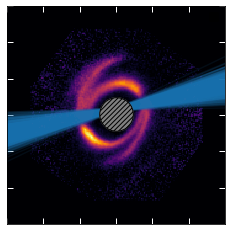

In [50]:
# Shadow 1
f_1, ax_1 = plt.subplots()

ax_1.imshow(im_median_1[:, ::-1],
            origin='lower',
            cmap=plt.get_cmap('inferno'),
            vmin=tmp_vmin,
            vmax=tmp_vmax,
            extent=(-(im_size - 1) / 2 * tmp_pixscale,
                  (im_size - 1) / 2 * tmp_pixscale,
                  -(im_size - 1) / 2 * tmp_pixscale,
                  (im_size - 1) / 2 * tmp_pixscale))

# ax_1.plot([], [], linestyle='none',
#           label=stellar_names_latex['LABEL'].data[mask_stellar_name_latex][0].replace('~', ' ') + r', $\mathbf{\Delta\theta_1}$')

# Plot coronagraph
coro_1 = Circle(xy=(-0.5 * tmp_pixscale, 0.5 * tmp_pixscale),
              radius=plot_parameters['CORO'].data[0],
               fill=True,
               hatch='/////',
               lw=1,
               color='grey',
               zorder=3)
coro_2 = Circle(xy=(-0.5 * tmp_pixscale, 0.5 * tmp_pixscale),
              radius=plot_parameters['CORO'].data[0],
               fill=False,
               hatch='/////',
               lw=1,
               color='k',
               zorder=4)
ax_1.add_patch(coro_1)
ax_1.add_patch(coro_2)

for i in range(1000):

    alpha_1 = np.random.choice(tmp_alpha_1_b, size=1)
    if 0 <= alpha_1 < 180:
        x_1 = -np.random.choice(tmp_x_1_b, size=1)
    else:
        x_1 = np.random.choice(tmp_x_1_b, size=1)

    # parameterize the shadow line
    p_1_1 = [0, x_1 * stellar_parameters['Plx'].data[stellar_parameters['NAME'].data == t][0] / 1000]
    p_2_1 = [-1 * np.sin(np.deg2rad(alpha_1)), p_1_1[1] + np.cos(np.deg2rad(alpha_1))]

    b_1_1 = p_1_1[0]
    b_2_1 = p_1_1[1]
    a_1_1 = p_2_1[0] - b_1_1
    a_2_1 = p_2_1[1] - b_2_1

    tt = np.linspace(-10, 10, 1000)
    xx_1 = lambda t: a_1_1 * t + b_1_1
    yy_1 = lambda t: a_2_1 * t + b_2_1

    ax_1.plot(xx_1(tt[::-1]), yy_1(tt), color='C0', alpha=0.1)

ax_1.invert_xaxis()
ax_1.set_xlim((im_size - 1) / 2 * tmp_pixscale, -(im_size - 1) / 2 * tmp_pixscale)
ax_1.set_ylim(-(im_size - 1) / 2 * tmp_pixscale, (im_size - 1) / 2 * tmp_pixscale)

leg = ax_1.legend(loc='upper right',
                  frameon=True,
                  prop={"weight": "bold", "size": 12},
                  markerfirst=False,
                  # bbox_to_anchor=(1.6, 1),
                  handletextpad=-2.,
                  # handlelength=0,
                  facecolor='k',
                  framealpha=0.6
                  )
leg.get_frame().set_linewidth(0.0)
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color=f'w')


# tick parameters
ax_1.tick_params(axis="both",
                 reset=False,
                 which="both",
                 direction="in",
                 length=6.,
                 width=1.,
                 labelsize=12,
                 colors="w",
                 labelcolor="k",
                 top=True,
                 bottom=True,
                 right=True,
                 left=True,
                 labelbottom=False,
                 labeltop=False,
                 labelright=False,
                 labelleft=False)
plt.show()
plt.close(f_1)

No handles with labels found to put in legend.


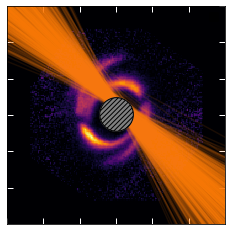

In [51]:
# Shadow 2
f_2, ax_2 = plt.subplots()

ax_2.imshow(im_median_1[:, ::-1],
            origin='lower',
            cmap=plt.get_cmap('inferno'),
            vmin=tmp_vmin,
            vmax=tmp_vmax,
            extent=(-(im_size - 1) / 2 * tmp_pixscale,
                  (im_size - 1) / 2 * tmp_pixscale,
                  -(im_size - 1) / 2 * tmp_pixscale,
                  (im_size - 1) / 2 * tmp_pixscale))

# Plot coronagraph
coro_1 = Circle(xy=(-0.5 * tmp_pixscale, 0.5 * tmp_pixscale),
              radius=plot_parameters['CORO'].data[0],
               fill=True,
               hatch='/////',
               lw=1,
               color='grey',
               zorder=3)
coro_2 = Circle(xy=(-0.5 * tmp_pixscale, 0.5 * tmp_pixscale),
              radius=plot_parameters['CORO'].data[0],
               fill=False,
               hatch='/////',
               lw=1,
               color='k',
               zorder=4)
ax_2.add_patch(coro_1)
ax_2.add_patch(coro_2)

for i in range(1000):

    alpha_2 = np.random.choice(tmp_alpha_2_b, size=1)
    if 0 <= alpha_2 < 180:
        x_2 = -np.random.choice(tmp_x_2_b, size=1)
    else:
        x_2 = np.random.choice(tmp_x_2_b, size=1)

    # parameterize the shadow line
    p_1_2 = [0, x_2 * stellar_parameters['Plx'].data[stellar_parameters['NAME'].data == t][0] / 1000]
    p_2_2 = [-1 * np.sin(np.deg2rad(alpha_2)), p_1_2[1] + np.cos(np.deg2rad(alpha_2))]

    b_1_2 = p_1_2[0]
    b_2_2 = p_1_2[1]
    a_1_2 = p_2_2[0] - b_1_2
    a_2_2 = p_2_2[1] - b_2_2

    tt = np.linspace(-10, 10, 1000)
    xx_2 = lambda t: a_1_2 * t + b_1_2
    yy_2 = lambda t: a_2_2 * t + b_2_2

    ax_2.plot(xx_2(tt[::-1]), yy_2(tt), color='C1', alpha=0.1)

ax_2.invert_xaxis()
ax_2.set_xlim((im_size - 1) / 2 * tmp_pixscale, -(im_size - 1) / 2 * tmp_pixscale)
ax_2.set_ylim(-(im_size - 1) / 2 * tmp_pixscale, (im_size - 1) / 2 * tmp_pixscale)

leg = ax_2.legend(loc='upper right',
                  frameon=True,
                  prop={"weight": "bold", "size": 12},
                  markerfirst=False,
                  # bbox_to_anchor=(1.6, 1),
                  handletextpad=-2.,
                  # handlelength=0,
                  facecolor='k',
                  framealpha=0.6
                  )
leg.get_frame().set_linewidth(0.0)
for i, text in enumerate(leg.get_texts()):
    plt.setp(text, color=f'w')


# tick parameters
ax_2.tick_params(axis="both",
                 reset=False,
                 which="both",
                 direction="in",
                 length=6.,
                 width=1.,
                 labelsize=12,
                 colors="w",
                 labelcolor="k",
                 top=True,
                 bottom=True,
                 right=True,
                 left=True,
                 labelbottom=False,
                 labeltop=False,
                 labelright=False,
                 labelleft=False)
plt.show()
plt.close(f_2)

In [52]:
# ---- Simulate coplanar orientation and corresponding posterior distribution
tmp_M1_sim_b = np.rad2deg(get_mis(np.deg2rad(np.random.choice(tmp_i_in_b - (np.nanmedian(tmp_i_in_b) - np.nanmedian(tmp_i_out_dist)), len(tmp_i_out_dist))),
                                  np.deg2rad(np.random.choice(tmp_pa_in_b - (np.nanmedian(tmp_pa_in_b) - np.nanmedian(tmp_pa_out_dist)), len(tmp_pa_out_dist))),
                                  np.deg2rad(np.random.choice(tmp_i_out_dist, len(tmp_i_out_dist))),
                                  np.deg2rad(np.random.choice(tmp_pa_out_dist, len(tmp_pa_out_dist)))))
tmp_M1_sim_b = tmp_M1_sim_b[np.invert(np.isnan(tmp_M1_sim_b))]
tmp_M2_sim_b = np.rad2deg(get_mis(np.deg2rad(np.random.choice(tmp_i_in_b - (np.nanmedian(tmp_i_in_b) - np.nanmedian(tmp_i_out_dist)), len(tmp_i_out_dist))),
                                  np.deg2rad(np.random.choice(tmp_pa_in_b - (np.nanmedian(tmp_pa_in_b) - np.nanmedian(tmp_pa_out_dist)), len(tmp_pa_out_dist))),
                                  -np.deg2rad(np.random.choice(tmp_i_out_dist, len(tmp_i_out_dist))),
                                  np.deg2rad(np.random.choice(tmp_pa_out_dist, len(tmp_pa_out_dist)))))
tmp_M2_sim_b = tmp_M2_sim_b[np.invert(np.isnan(tmp_M2_sim_b))]

In [53]:
# peform KS test
statistic, pvalue = kstest(rvs=np.hstack((tmp_M1_b, tmp_M2_b)),
                           cdf=np.hstack((tmp_M1_sim_b, tmp_M2_sim_b)),
                           )
n = len(np.hstack((tmp_M1_b, tmp_M2_b)))
m = len(np.hstack((tmp_M1_sim_b, tmp_M2_sim_b)))
c_alpha = statistic * np.sqrt(n * m / (n + m))
alpha = 2 * np.exp(-2 * c_alpha ** 2)

statistic_1_1, pvalue_1_1 = kstest(rvs=tmp_M1_b,
                           cdf=tmp_M1_sim_b,
                           )
n_1_1 = len(tmp_M1_sim_b)
m_1_1 = len(tmp_M1_b)
c_alpha_1_1 = statistic_1_1 * np.sqrt(n_1_1 * m_1_1 / (n_1_1 + m_1_1))
alpha_1_1 = 2 * np.exp(-2 * c_alpha_1_1 ** 2)

In [54]:
statistic_1_2, pvalue_1_2 = kstest(rvs=tmp_M1_b,
                           cdf=tmp_M2_sim_b,
                           )
n_1_2 = len(tmp_M2_sim_b)
m_1_2 = len(tmp_M1_b)
c_alpha_1_2 = statistic_1_2 * np.sqrt(n_1_2 * m_1_2 / (n_1_2 + m_1_2))
alpha_1_2 = 2 * np.exp(-2 * c_alpha_1_2 ** 2)
statistic_2_1, pvalue_2_1 = kstest(rvs=tmp_M2_b,
                           cdf=tmp_M1_sim_b,
                           )
n_2_1 = len(tmp_M1_sim_b)
m_2_1 = len(tmp_M2_b)
c_alpha_2_1 = statistic_2_1 * np.sqrt(n_2_1 * m_2_1 / (n_2_1 + m_2_1))
alpha_2_1 = 2 * np.exp(-2 * c_alpha_2_1 ** 2)
statistic_2_2, pvalue_2_2 = kstest(rvs=tmp_M2_b,
                           cdf=tmp_M2_sim_b,
                           )
n_2_2 = len(tmp_M2_sim_b)
m_2_2 = len(tmp_M2_b)
c_alpha_2_2 = statistic_2_2 * np.sqrt(n_2_2 * m_2_2 / (n_2_2 + m_2_2))
alpha_2_2 = 2 * np.exp(-2 * c_alpha_2_2 ** 2)

In [55]:
ks_statistics = np.min([np.max([statistic_1_1, statistic_2_2]),
                                 np.max([statistic_1_2, statistic_2_1]),])

print(f'KS Statistic: {ks_statistics}')

KS Statistic: 0.9999


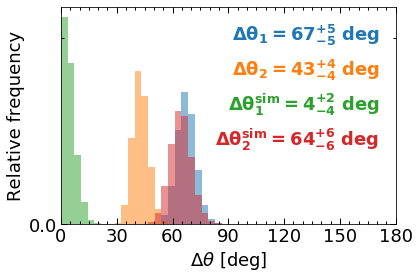

In [56]:
fig_1, ax_1 = plt.subplots()
ax_1.hist(tmp_M1_b,
          bins=50,
          range=(0, 180),
          alpha=0.5,
          weights=np.zeros_like(tmp_M1_b) + 1./2e5)
ax_1.hist(tmp_M2_b,
          bins=50,
          range=(0, 180),
          alpha=0.5,
          weights=np.zeros_like(tmp_M2_b) + 1./2e5)
ax_1.hist(tmp_M1_sim_b,
          bins=50,
          range=(0, 180),
          alpha=0.5,
          weights=np.zeros_like(tmp_M1_sim_b) + 1./2e5)
ax_1.hist(tmp_M2_sim_b,
          bins=50,
          range=(0, 180),
          alpha=0.5,
          weights=np.zeros_like(tmp_M2_sim_b) + 1./2e5)

ax_1.plot([], [], linestyle='none', label=rf'$\mathbf{{\Delta\theta_1={{{np.median(tmp_M1_b):.0f}}}^{{+{np.diff(np.percentile(tmp_M1_b, [16, 50]))[0]:.0f}}}_{{-{np.diff(np.percentile(tmp_M1_b, [50, 84]))[0]:.0f}}}}}$ deg')
ax_1.plot([], [], linestyle='none', label=rf'$\mathbf{{\Delta\theta_2={{{np.median(tmp_M2_b):.0f}}}^{{+{np.diff(np.percentile(tmp_M2_b, [16, 50]))[0]:.0f}}}_{{-{np.diff(np.percentile(tmp_M2_b, [50, 84]))[0]:.0f}}}}}$ deg')
ax_1.plot([], [], linestyle='none', label=rf'$\mathbf{{\Delta\theta_1^{{sim}}={{{np.median(tmp_M1_sim_b):.0f}}}^{{+{np.diff(np.percentile(tmp_M1_sim_b, [16, 50]))[0]:.0f}}}_{{-{np.diff(np.percentile(tmp_M1_sim_b, [50, 84]))[0]:.0f}}}}}$ deg')
ax_1.plot([], [], linestyle='none', label=rf'$\mathbf{{\Delta\theta_2^{{sim}}={{{np.median(tmp_M2_sim_b):.0f}}}^{{+{np.diff(np.percentile(tmp_M2_sim_b, [16, 50]))[0]:.0f}}}_{{-{np.diff(np.percentile(tmp_M2_sim_b, [50, 84]))[0]:.0f}}}}}$ deg')

leg_1 = ax_1.legend(loc='upper right',
            frameon=True,
            prop={"weight": "bold", "size": 18},
            markerfirst=False,
            # bbox_to_anchor=(1.6, 1),
            handletextpad=-2.,
                # handlelength=0,
                facecolor='w',
                framealpha=0.6
            )
leg_1.get_frame().set_linewidth(0.0)
for i, text in enumerate(leg_1.get_texts()):
    plt.setp(text, color=f'C{i}')
ax_1.set_xlim(0,180)
# ax_1.set_ylim(0,1)
ax_1.set_xlabel(r'$\Delta\theta$ [deg]', fontsize=18)
ax_1.set_ylabel(r'Relative frequency', fontsize=18)

ax_1.xaxis.set_major_locator(MultipleLocator(30))
ax_1.xaxis.set_minor_locator(MultipleLocator(5))
ax_1.yaxis.set_major_locator(MultipleLocator(0.1))
ax_1.yaxis.set_minor_locator(MultipleLocator(0.02))

# tick parameters
ax_1.tick_params(axis="both",
               reset=False,
               which="major",
               direction="in",
               length=6.,
               width=1.,
               labelsize=18,
               colors="k",
               labelcolor="k",
               top=True,
               bottom=True,
               right=True,
               left=True,
               labelbottom=True,
               labeltop=False,
               labelright=False,
               labelleft=True)

# tick parameters
ax_1.tick_params(axis="both",
               reset=False,
               which="minor",
               direction="in",
               length=3.,
               width=1,
               labelsize=18,
               colors="k",
               labelcolor="black",
               top=True,
               bottom=True,
               right=True,
               left=True,
               labelbottom=True,
               labeltop=True,
               labelright=True,
               labelleft=True)


plt.show()
plt.close(fig_1)